# Climate case study

The two case studies in this folder from climate science and biogeosciences follow the QAD-questionnaire and method-selection flow chart in the following Review paper (included in the tigramite github tutorial folder):

Runge, J., Gerhardus, A., Varando, G., Eyring, V. & Camps-Valls, G. Causal inference for time series. Nat. Rev. Earth Environ. 10, 2553 (2023).

A list of methods with software to address selected QAD problems appears at the end of that Review paper.

This case study considers the Walker Circulation as an example where the causal physical mechanisms are reasonably well understood in terms of so-called climate teleconnections. See the more detailed discussion in the paper.

The focus is on the equatorial Western-Central Pacific branch of the Walker Circulation. This branch of the circulation describes a clock-wise large-scale time-mean circulation of falling air masses in the Central Pacific (CPAC), westward surface tradewinds in the Western-central pacific (WCPAC), and rising air masses in the western Pacific (WPAC) as, for example, illustrated in [this schematic](https://www.climate.gov/news-features/blogs/enso/walker-circulation-ensos-atmospheric-buddy). This circulation is known to exhibit a regime-dependence in that it strengthens during its La Nina phases, defined by anomalously cool ocean temperatures in the central-eastern Pacific, and weakens (or even reverses and shifts eastward) during El Nino phases, defined by anomalously warm ocean temperatures. In addition, the circulation also exhibits a seasonal regime-dependence with the circulation strength peaking in winter. The below analysis aims to gain a causal understanding of the anomalous circulation during winter-time neutral or La Nina phases.

Let's start with some imports of standard python packages as well as the tigramite causal inference package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

## Data loading and pre-processing

The primary research question is to quantify the causal effects among the involved processes. Closely following the QAD-questionnaire (see paper), the first step is to define and construct the variables of interest. Here the underlying ERA5 reanalysis data comes on a latitude-longitude grid and dimension-reduction needs to be employed. As motivated in the case study figure of the paper in panel (a), the WPAC and CPAC indices are chosen as variables because they correspond to major regions of, respectively, ascending and descending air masses as measured by their correlation with the Nino3.4 index. The WCPAC index, which measures the surface zonal wind in between the two regions, is chosen as a third variable. 

The three variables in the folder `/climate_data/` and were generated with the KNMI climate explorer (https://climexp.knmi.nl/), see the headers of the files for details.

In [2]:
# Pick time range
start_year = 1950
length = 12*(2022 - start_year)

# Load the three climate time series
# (these were generated with the KNMI climate explorer, see the headers of the files for details)
data = np.vstack((
    np.loadtxt('climate_data/iera5_w700_130-150E_20-0N_n.dat', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('climate_data/iera5_u10m_160-180E_5--5N_n.dat', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('climate_data/iera5_w700_-160--120E_5--5N_n.dat', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = data.shape

# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'WCPAC', 'CPAC']

These three variables are all continuously-valued and are, as the next step, also temporally aggregated to a 2-monthly time resolution in order to average-out noisy monthly variability. This procedure defines a single observational dataset of three bi-monthly time series. 

In [3]:
# Time-bin data and datatime
data, _ = pp.time_bin_with_mask(data,
    time_bin_length=2, mask=None)
datatime, _ = pp.time_bin_with_mask(datatime,
    time_bin_length=2, mask=None)

The next question (see QAD flow chart) is about stationarity. A trend and seasonal cycle can introduce non-stationary dependencies that cannot be explained causally, that is, can act as confounders. Hence, as pre-processing steps, the trend and seasonal cycle are removed by first substracting both the trend (assumed to be caused by, for example, greenhouse gas forcing) and the seasonal cycle and then dividing by the seasonal variance. The length scale of the Gaussian kernel used for finding the long-term trend is assumed to be decadal ($15$ years). 

In [4]:
# Smooth-width set to 15 years
cycle_length = 6   # a year in bi-monthly time resolution 
smooth_width = 15*cycle_length

if smooth_width is not None:
    smoothdata_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=False)
    data_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    print("Not smoothed.")
    data_here = np.copy(data)

# Remove seasonal mean and divide by seasonal standard deviation
seasonal_cycle = anomalize(np.copy(data_here), cycle_length=cycle_length, return_cycle=True)
smoothdata_here += seasonal_cycle

Further, considering the regime behavior of the system as explained above, only the periods November to February during the neutral or La Ni\~na phases (defined by the 5-month running mean of the Nino3.4 index below 0.5$^\circ$K) are considered. On a technical level, this selection of considered time periods is achieved by applying a so-called mask (also see [masking tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/dataset_challenges/tigramite_tutorial_missing_masking.ipynb) in tigramite).

More specifically, here the mask is such that samples for WPAC, WCPAC, and CPAC at time $t$ can only come from Nov-Feb in neutral or La Nina conditions, while samples for the times $t-1$ and $t-2$ can also come from outside this mask. This masking procedure results in a small sample size of $n=110$ during the years 1950-2021 (there are even fewer samples for El Nino phases), but at least these sample can reasonably be assumed to come from the same stationary distribution. 

In [5]:
# Oceanic Nino Index defined by 5 consecutive months of 3-month-running-mean of Nino3.4 SST above/below 0.5
nino34 = np.loadtxt('climate_data/iersst_nino3.4a.txt', skiprows=44)[(start_year-1854)*12:(start_year-1854)*12+length,1]
nino34smoothed = pp.smooth(nino34, smooth_width=3, kernel='heaviside',
           mask=None, residuals=False)

# Construct mask for only neutral and La Nina phases
nino_mask = np.zeros(length)
for t in range(length):
    if np.sum(nino34smoothed[max(0, t-4): min(length, t+5)] > 0.5) >= 5:
        nino_mask[t] = 1

# Time-bin mask since we will use bimonthly time series
nino_mask, _ = pp.time_bin_with_mask(nino_mask,
    time_bin_length=2, mask=None)

# Construct mask to only select November to February 
# (cycle_length is the length of the year in the bimonthly time series)
cycle_length = 6
mask = np.ones(data.shape, dtype='bool')
for i in [0, 5]:
    mask[i::cycle_length, :] = False

# Additionally masking to pick only neutral and La Nina phases
for t in range(mask.shape[0]):
    if nino_mask[t] >= 0.5:
        mask[t] = True

The figure below shows (in black) the raw data and overlaid (in red) the sum of 1) the low-frequency variability including the long-term trend, which is obtained by smoothing the time series using a Gaussian kernel with 15-year length scale, and 2) the seasonal cycle of the detrended residuals. Masked samples are in grey.

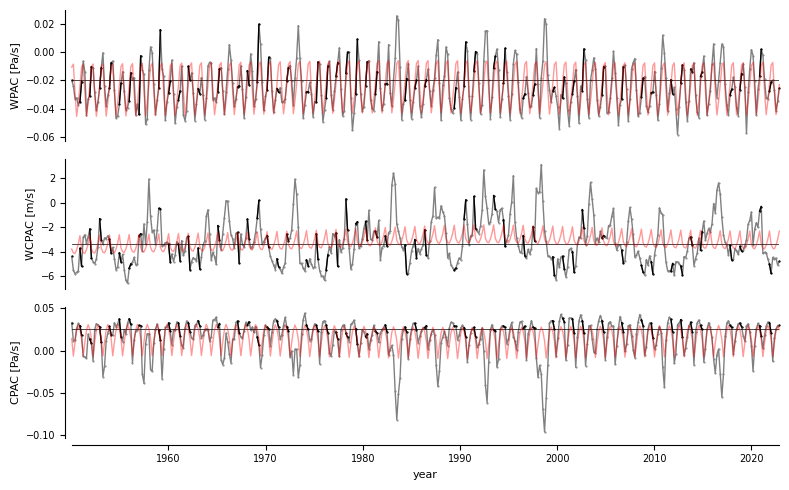

In [6]:
# Dataframe for raw data
raw_dataframe = pp.DataFrame(np.copy(data), mask=mask, var_names=var_names, datatime=datatime)

# Dataframe for smoothed data
smoothdataframe_here = pp.DataFrame(smoothdata_here, var_names=var_names,  datatime=datatime)

fig, axes = tp.plot_timeseries(
        raw_dataframe,
        figsize=(8, 5),
        grey_masked_samples='data',
        color='black',
        show_meanline=True,
        adjust_plot=False,
        )  

tp.plot_timeseries(
        smoothdataframe_here,
        fig_axes = (fig, axes),
        grey_masked_samples='data',
        show_meanline=False,
        color='red',
        alpha=0.4,
        adjust_plot=True,
        tick_label_size=7,
        label_fontsize=8,
        time_label='year',
        var_units=['Pa/s', 'm/s', 'Pa/s',],
#         save_name="timeseries.pdf"
        ); plt.show()

We now continue with the pre-processed data.

In [7]:
if smooth_width is not None:
    data_here = pp.smooth(data=np.copy(data), smooth_width=smooth_width, kernel='gaussian',
                    residuals=True)
else:
    data_here = np.copy(data)

data_here = anomalize(data_here, cycle_length=cycle_length)

# Initialize Tigramite dataframe with mask, missing_flag is not needed here
dataframe = pp.DataFrame(data_here, mask=mask, var_names=var_names, missing_flag=999.)

## Causal effect analysis

The causal question is now about causal effect estimation and mediation. This quantification requires qualitative knowledge about cause-and-effect relationships in form of the causal time series graph. Causal discovery, that is, to learn the causal graph from the data, is challenging for such short sample sizes, so domain knowledge is used to come up with the qualitative feedback graph shown below with the time lags roughly based on the wind velocities in Gushchina et al. 2020 (see paper). 

The process graph (sometimes also referred to as summary graph) on the left aggregates the time series graph which explicitely depicts the time-dependent structure. Since atmospheric processes are fast, contemporaneous causal effects are assumed (that is, causal influences on a time scale below data's time resolution of 2 months). However, for simplicity, it is assumed that there are no contemporaneous causal cycles (that is, if, for example, WPAC$_t$ had a causal influence on CPAC$_t$, then CPAC$_t$ could not have a causal influence on WPAC$_t$, and vice versa).

See the [causal effect tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_general_causal_effect_analysis.ipynb) for how to specify graphs. 

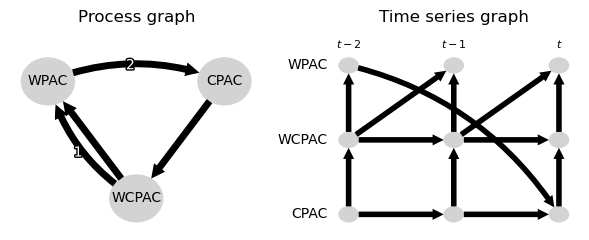

In [8]:
# Causal effect estimation
# Graph has shape (N, N, tau_max + 1)
graph = np.array([
        [['', '', ''],
        ['<--', '', ''],
        ['', '', '-->']],

       [['-->', '-->', ''],
        ['', '-->', ''],
        ['<--', '', '']],

       [['', '', ''],
        ['-->', '', ''],
        ['', '-->', '']]], dtype='<U3')

# Positions of nodes for process graph
node_pos =  {
            'y': np.array([0.5, 0., 0.5, 1.]),
            'x': np.array([0., 0.5, 1., .5])
            }

# Show both graphs next to each other
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 2.5))

tp.plot_graph(
    fig_ax = (fig, axes[0]),
    graph = graph,
    node_pos=node_pos,
    arrow_linewidth=5,
    node_size=0.2,
    node_aspect=1.5,
    var_names=var_names,
    tick_label_size=6,
    )
axes[0].set_title('Process graph', pad=20)

tp.plot_time_series_graph(
    fig_ax = (fig, axes[1]),
    graph = graph,
    var_names=var_names,
    )
axes[1].set_title('Time series graph', pad=20)

fig.tight_layout()

One can argue about which graph to assume here. For example, one may integrate hidden confounders, that is, unobserved variables which causally influence two observed variables (see the biogeoscience example). Here, due to the above pre-processing steps for removing long-terms trend and seasonal cycles, as well as restricting to time periods across which stationarity can be assumed, one might reasonably assume the absence of hidden confounding. A more thorough analysis could, for example, in addition consider interdependencies with sea-surface temperature as a possible source of hidden confounding. The strength of causal inference lies in transparently laying out such assumptions.

With this graph the causal question is, firstly, on total causal effect estimation and, secondly, on linear mediation analysis amond the three variables (for theory on these topcis see the section on causal effects in the Review paper). 

According to the QAD flow chart, here there is only a single dataset. Starting with  $X=\text{CPAC}_{t}$ on  $Y=\text{WPAC}_{t}$, the total causal effect along the causal chain CPAC$_t \to $WCPAC$_t \to $WPAC$_t$ in the graph has no hidden confounders. Further, given the short sample size, a linearity assumption is reasonable which suggests the path method according to the flow chart. 

However, it is prudent to also evaluate alternative methods, here by means of covariate adjustment using the optimal adjustment set $\mathbf{Z}=\{\text{WCPAC}_{t-1}\}$ (for theory see the paragraphs on covariate adjustment, optimal adjustment and linear causal effect estimation and the path method in the section on causal effects in the paper). 

### (Optimal) adjustment for causal effect estimation

This will use the ``CausalEffects`` class of Tigramite, see the [corresponding tutorial]().

X = [('CPAC', 0)] -----> Y = [('WPAC', 0)]
Oset =  [('WCPAC', -1)]


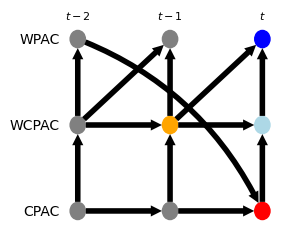

In [9]:
# Define cause X and effect Y
X = [(2, 0)]
Y = [(0, 0)]

# Initialize class with stationary directed acyclic graph (DAG) defined above
causal_effects = CausalEffects(graph, graph_type='stationary_dag', 
                                    X=X, Y=Y, 
                                   S=None, # S could be a modulating variable to estimate conditional causal effects
                                   verbosity=0)

print("X = %s -----> Y = %s" % (str([(var_names[var[0]], var[1]) for var in X]), str([(var_names[var[0]], var[1]) for var in Y])))

# Get optimal adjustment set
opt = causal_effects.get_optimal_set()

if opt is False: print("NOT IDENTIFIABLE!")
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
# Optionally check whether here an optimal adjustment set exists 
# in the sense that it has the smallest asymptotic variance among all adjustment sets (see [Runge 2021](https://arxiv.org/abs/2102.10324))
# print("Optimality = %s" %str(causal_effects.check_optimality()))

# Color nodes
special_nodes = {}
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
    
fig, ax = tp.plot_time_series_graph(
        graph = graph,
        special_nodes=special_nodes,
        var_names=var_names,
        figsize=(3, 2.5),
        )
plt.tight_layout()

The mediator is shown in light blue. The conditioning set $\mathbf{Z}$ blocks non-causal confounding of $X$ and $Y$ by $\text{CPAC}_{t-1}$ as well as by further lagged confounders.

We now fit and predict the total effect of X on Y using the ``fit_total_effect`` function and obtain an uncertainty estimate using the ``fit_bootstrap_of`` function. Here setting the interventions to 0 and 1 and computing the difference of the corresponding predictions yields a causal effect that corresponds to the linear regression coefficient. Note that due to the anomalization performed above, the data is approximately standardized.

In [10]:
# Optional data transform
data_transform = None  # sklearn.preprocessing.StandardScaler()

# Confidence interval range
conf_lev = 0.9

# Fit causal effect model from observational data
causal_effects.fit_total_effect(
    dataframe=dataframe, 
    mask_type='y',
    estimator=LinearRegression(),
    data_transform=data_transform,
    )

# Fit bootstrap causal effect model
causal_effects.fit_bootstrap_of(
    method='fit_total_effect',
    method_args={'dataframe':dataframe,  
    'mask_type':'y',
    'estimator':LinearRegression(),
    'data_transform':data_transform,
    },
    seed=4
    )

# Define interventions
dox_vals = np.linspace(0., 1., 2)

# Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
pred_Y = causal_effects.predict_total_effect( 
        intervention_data=intervention_data)

# Bootstrap: Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
conf = causal_effects.predict_bootstrap_of(
    method='predict_total_effect',
    method_args={'intervention_data':intervention_data},
    conf_lev=conf_lev)

print("Total effect via adjustment = %.2f [%.2f, %.2f]"
        %(pred_Y[1]-pred_Y[0], conf[0,1]-conf[0,0], conf[1,1]-conf[1,0])) 


Total effect via adjustment = -0.31 [-0.39, -0.11]


### Wright's path-method for causal effect estimation

To this end, since there are no unobserved nodes assumed, we can use Wright's path-method functionality in the ``CausalEffects``-class. We will wrap the method including the bootstrap confidence interval estimation into a fuction.

In [11]:
def get_path_effect(graph, X, Y, mediation=None, conf_lev=0.9):
    causal_effects = CausalEffects(graph, graph_type='stationary_dag', 
                                    X=X, Y=Y, 
                                   S=None, 
                                   verbosity=0)
    
    dox_vals = np.linspace(0., 1., 2)

    # Fit causal effect model from observational data
    causal_effects.fit_wright_effect(
        dataframe=dataframe, 
        mask_type='y',
        mediation=mediation, #'direct',
        method = 'parents',
        data_transform=data_transform, #sklearn.preprocessing.StandardScaler(),
        )

    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    pred_Y = causal_effects.predict_wright_effect( 
            intervention_data=intervention_data)

    # Fit causal effect model from observational data
    causal_effects.fit_bootstrap_of(
        method='fit_wright_effect',
        method_args={'dataframe':dataframe,  
        'mask_type':'y',
        'mediation':mediation, #'direct',
        'data_transform':data_transform,
        },
        seed=42
        )

    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    conf = causal_effects.predict_bootstrap_of(
        method='predict_wright_effect',
        method_args={'intervention_data':intervention_data},
        conf_lev=conf_lev)

    print("Wright's path effect    = %.2f [%.2f, %.2f]"
                %(pred_Y[1], conf[0,1], conf[1,1]))


In [12]:
get_path_effect(graph, X=X, Y=Y, mediation=None, conf_lev=0.9)

Wright's path effect    = -0.24 [-0.40, -0.09]


Here we get a similar total effect via the path method. Notice the larger confidence interval for the path method in this case.

## Linear mediation analysis

Finally, a linear mediation analysis assuming no latent confounders (for theory see the paragraph linear mediation analysis in the section on causal effects in the paper) can also be conducted by the path method. The linear mediated effect of $X=\text{WCPAC}_{t-1}$ on $Y=\text{WPAC}_{t}$ through $M=\text{WCPAC}_{t}$ (see graph) is:

In [13]:
get_path_effect(graph, X=[(1, -1)], Y=[(0, 0)], mediation=[(1, 0)], conf_lev=0.9)

Wright's path effect    = 0.33 [0.10, 0.50]


On the other hand, the direct effect, that is not mediated through $M$, is:

In [14]:
get_path_effect(graph, X=[(1, -1)], Y=[(0, 0)], mediation='direct', conf_lev=0.9)

Wright's path effect    = 0.31 [0.12, 0.52]


The mediated and non-mediated effect sum up to the total causal effect:

In [15]:
get_path_effect(graph, X=[(1, -1)], Y=[(0, 0)], mediation=None, conf_lev=0.9)

Wright's path effect    = 0.64 [0.52, 0.79]


All these effects are in units of the seasonally-standardized data.

As a note, because there is no hidden confounding here, you can also use the (often) faster ``LinearMediation`` class for linear causal effect and mediation estimation  (see [tutorial on linear mediation](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_linear_causal_effects_mediation.ipynb)). To this end, you need to provide the class with the parents of all nodes (read-off from the graph):

In [16]:
parents = {}
for j in range(causal_effects.N):
    parents[j] = list(causal_effects._get_parents((j, 0)))
print(parents)

{0: [(1, 0), (1, -1)], 1: [(2, 0), (1, -1)], 2: [(2, -1), (0, -2)]}


Then we can initialize the ``LinearMediation`` class and fit the link coefficients, including bootstrap estimates of their uncertainty.

In [17]:
med = LinearMediation(dataframe=dataframe,
                 data_transform=data_transform,
                 mask_type='y',)
med.fit_model(all_parents=parents, tau_max=graph.shape[2] - 1)
med.fit_model_bootstrap( 
            boot_blocklength=1,
            seed=4,
            boot_samples=200)

def get_linear_mediation_effect(i, j, tau, mediation=None, conf_lev=0.9):
    ce = med.get_ce(i=i, tau=tau,  j=j)
    ce_boots = med.get_bootstrap_of(function='get_ce', 
        function_args={'i':i, 'tau':tau,  'j':j}, conf_lev=0.9)
    # Get Causal effect and 90% confidence interval
    print(f"Effect of {i} on {j} with mediation = {mediation} is {ce:.2f} [{ce_boots[0]:.2f}, {ce_boots[1]:.2f}]")

In [18]:
get_linear_mediation_effect(i=2, j=0, tau=0, mediation=None, conf_lev=0.9)
get_linear_mediation_effect(i=2, j=0, tau=0, mediation=1, conf_lev=0.9)

get_linear_mediation_effect(i=1, j=0, tau=1, mediation=None, conf_lev=0.9)

Effect of 2 on 0 with mediation = None is -0.24 [-0.49, -0.07]
Effect of 2 on 0 with mediation = 1 is -0.24 [-0.49, -0.07]
Effect of 1 on 0 with mediation = None is 0.64 [0.50, 0.77]


Note that, different from ``CausalEffects``, the  ``LinearMediation`` class works on the process-level and mediation is computed differently: ``mediation=1`` computes all paths throuth variable 1 at *any* lag. Here this does not allow to differentiate mediation through the contemporaneous node of variable 1. The ``CausalEffects`` class allows to specify mediation at different lags. 

The ``LinearMediation`` class provides a wealth of further functionality. Have a look at the tutorial.

This example demonstrates how domain knowledge, such as variable definitions and an assumed qualitative graph, in combination with pre-processing steps to assure certain assumptions, are leveraged in a causal inference analysis to quantify causal effects. 

There are many ways to modify the setup of this analysis: from choosing different variables, over accounting for confounding by sea-surface temperature, to different pre-processing steps and alternative assumptions about the graph. A more comprehensive analysis can and would transparently report how these different assumptions change the conclusions. 

Have a look at other tutorials on various methods and functionality of tigramite.